In [9]:
import sqlite3
import feedparser
import re
from bs4 import BeautifulSoup
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
from corextopic import corextopic as ct
import umap, umap.plot


count = 0

# list of feed urls loaded from the db
feed_url_list = []

# dict of feeds
# urls are keys and features (body of text) are values
feeds = dict()

# normalizes a string 
# - remove HTML tags (using BeautifulSoup)
# - convert to lower case
# - remove numbers
# - remove symbols
# - remove stop words (using NLTK)
def normalize(text):

    # remove HTML tags
    text = BeautifulSoup(text, 'html.parser').get_text()

    # convert to lower case
    text = text.lower()

    # remove numbers
    text = re.sub(r'\d+', '', text)

    # remove symbols
    text = text.replace('\n', ' ')
    text = re.sub(r'[^A-Za-z ]+', '', text)
    text = re.sub(r' +', ' ', text)

    # remove stop words
    tokenized = word_tokenize(text)
    text = ' '.join([word for word in tokenized if not word in stopwords.words('english')])

    return text

# load feeds from the db
# specify how many feeds to load from the database
def loadFeeds(no_feeds):

    # clear feed urls list and feeds dict
    feed_url_list.clear()
    feeds.clear()

    global count
    count = 0

    print('Loading feed urls...')

    # connect to the db
    conn = sqlite3.connect('feeds_dev.db')
    c = conn.cursor()

    # select urls 
    # add limit 100 during development
    c.execute('SELECT url FROM feeds LIMIT ?;', (no_feeds,))
    for entry in c.fetchall():
        feed_url_list.append(entry[0])

    print('Loaded feeds\n')

# analyze a feed and generate its initial body of text
def parseFeed(url):

    global count
    count += 1
    print('Generating features for ', url, ' ', str(count))

    # return if the feed can not be parsed
    try:
        d = feedparser.parse(url)
    except Exception:
        print('Could not parse feed ', url)
        return

    # body of text representing the features
    features = ''

    # check that the feed has a title, description and at least one entry
    title = d['feed'].get('title')
    description = d['feed'].get('description')
    entries = d['entries']

    if title == None or description == None or len(entries) == 0:
        
        # feed is invalid
        return

    # feed is valid, continue feature extraction
    # add title and description to body of text
    features = title + ' ' + description

    # add the title and description of each entry to the body of text
    for entry in entries:
        
        entry_title = entry.get('title')
        entry_title = entry_title if entry_title is not None else ''

        entry_description = entry.get('description')
        entry_description = entry_description if entry_description is not None else ''

        features = features + ' ' + entry_title + ' ' + entry_description

    # normalize the body of text
    features = normalize(features)

    # add the features to the feed's dict entry
    feeds[url] = features


# Generate Features
Load the feeds from the database and generate a body of text for each feed. 
The body of text contains the feed's (processed) data.

In [ ]:
# save the features in the dict to the database
def saveFeatures():

    print('Saving features...')

    # connect to the db
    conn = sqlite3.connect('feeds_dev.db')
    c = conn.cursor()

    for url, features in feeds.items():
        c.execute('UPDATE feeds SET text = ? WHERE url = ?;', (features, url))

    # Commit and close connection
    conn.commit()
    conn.close()

    print('Saved features')

# generate features for the feeds
# specify for how many feeds to generate the features
def generateFeatures(no_feeds):

    loadFeeds(no_feeds)

    # generate features for all feeds
    for url in feed_url_list:   
        parseFeed(url)

    print('\nFeatures generated for ' + str(count) + ' urls\n')

    # save the features
    saveFeatures()

generateFeatures(1000)


# Load Features
Load the previously generated bodies of text for the feeds and load them into the feeds dict

In [10]:
def loadFeatures():

    print('Loading features...')

    # connect to the db
    conn = sqlite3.connect('feeds_dev.db')
    c = conn.cursor()
    
    # select only the feeds for which the body of text 
    # has already been generated
    c.execute('SELECT url, text FROM feeds WHERE text IS NOT NULL;')
    for entry in c.fetchall():
        feeds[entry[0]] = entry[1]

    print('Loaded features for ' + str(len(feeds)) + ' feeds')

loadFeatures()

Loading features...
Loaded features for 871 feeds


# Vectorize Documents
Create a doc-word matrix from the previously-generated bodies of text.

In [11]:
# returns the feeds dict's values as a doc-word matrix
def vectorizeDocuments():
    corpus = list(feeds.values())
    vectorizer = CountVectorizer(max_features=20000, binary=True)
    doc_word = vectorizer.fit_transform(corpus)

    # get the words (column labels)
    words = vectorizer.get_feature_names()

    return doc_word, words

# create a doc-word matrix from the dicts
doc_word, words = vectorizeDocuments()
docs = list(feeds.keys())

print('Shape of doc-word matrix: ', str(doc_word.shape))
print('Number of documents (labels): ', str(len(docs)))
print('Number of words (features): ', str(len(words)))

Shape of doc-word matrix:  (871, 20000)
Number of documents (labels):  871
Number of words (features):  20000


# CorEx Topic Modelling
Infer topics for the documents in the doc-word matrix


In [12]:
# train the CorEx topic model
topic_model = ct.Corex(n_hidden=10, words=words, docs=docs, max_iter=200, verbose=False, seed=1)
topic_model.fit(doc_word, words=words, docs=docs)

## Output

### Display all topics

In [13]:
topics = topic_model.get_topics()
for n,topic in enumerate(topics):
    topic_words,_,_ = zip(*topic)
    print('{}: '.format(n) + ', '.join(topic_words))

0: looks, taken, amount, least, leave, hard, later, close, room, far
1: let, per, anything, works, trying, eye, add, light, side, instead
2: call, risk, said, terms, required, support, increase, deal, remain, role
3: saturday, building, necessary, brings, named, success, service, series, stage, rolling
4: check, give, pretty, bit, black, wait, actually, shop, couple, nice
5: man, car, five, following, says, care, woman, company, tv, road
6: sweet, flavour, delicious, recipe, sauce, ingredients, meal, cheese, recipes, dish
7: easily, colours, colour, love, pieces, selection, bag, perfect, favourite, fish
8: government, legal, law, eu, minister, policy, brexit, boris, mps, uk
9: pattern, yarn, knitting, stitch, stitches, needle, knitters, sewing, yarns, crochet


### Display Top Documents 
Given a topic, display the top documents for that topic.

In [14]:
topic_model.get_top_docs(topic=0, n_docs=10, sort_by='log_prob')

[('https://thegreenish.co.uk/travel?format=rss', 0.0),
 ('https://isleofwhithorn.blogspot.com/feeds/posts/default?alt=rss', 0.0),
 ('https://www.esteelalonde.com/journal?format=rss', 0.0),
 ('http://scottishgenealogyblog.blogspot.com/feeds/posts/default?alt=rss',
  0.0),
 ('https://scottishboating.blogspot.com/feeds/posts/default', 0.0),
 ('https://chokkablog.blogspot.com/feeds/posts/default?alt=rss', 0.0),
 ('https://feeds.feedburner.com/globalhelpswap/PbLm', 0.0),
 ('http://feeds.feedburner.com/co/XRuB', 0.0),
 ('http://salmon-fishing-scotland.blogspot.com/feeds/posts/default?alt=rss',
  0.0),
 ('http://mountainandseascotland.blogspot.com/feeds/posts/default?alt=rss',
  0.0)]

### Assignments of Documents to Topics

In [15]:
# Estimation of the probability that a document belongs to a topic
print(topic_model.p_y_given_x.shape)

# Determine which document belongs to which topic
print(topic_model.labels.shape)
print(topic_model.labels[0])

(871, 10)
(871, 10)
[False False False False  True  True False False False  True]


# UMAP Plot

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<AxesSubplot:>

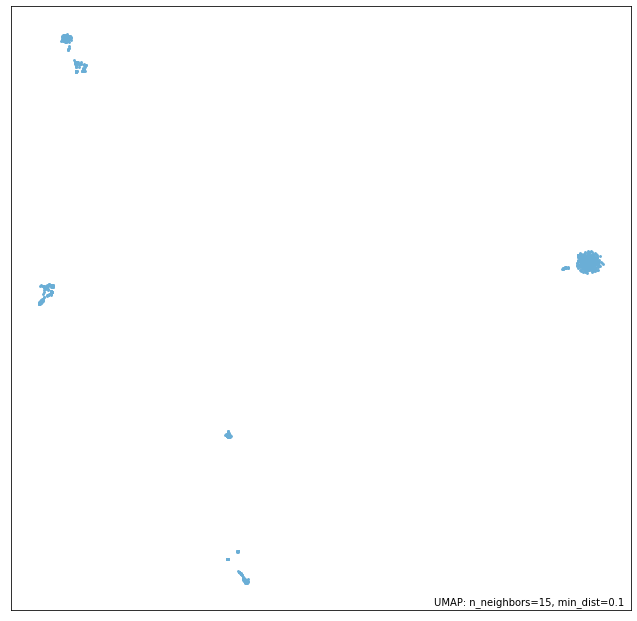

In [41]:
mapper = umap.UMAP().fit(topic_model.p_y_given_x)
umap.plot.points(mapper)